In [24]:
import pandas as pd
from PIL import Image
import numpy as np
import os
import regex as re
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch.nn as nn
import torch.optim as optim

In [25]:
# SPLIT INTO TRAIN AND TEST - RUN ONCE

import os
from sklearn.model_selection import train_test_split

# Define the path to the folder containing the data
data_dir = 'UTKFace copy'

# Define the percentage of the data to use for testing
test_size = 0.3

# Get a list of all the image file names in the data folder
image_files = os.listdir(data_dir)

# Split the image file names into train and test sets
train_files, test_files = train_test_split(image_files, test_size=test_size)

# Move the train files to a train folder and the test files to a test folder
train_dir = 'UTKFace_train'
test_dir = 'UTKFace_test'

for file_name in train_files:
    os.rename(os.path.join(data_dir, file_name), os.path.join(train_dir, file_name))

for file_name in test_files:
    os.rename(os.path.join(data_dir, file_name), os.path.join(test_dir, file_name))


FileNotFoundError: [Errno 2] No such file or directory: 'UTKFace copy'

In [28]:
image_data = []
counter = 0

# loop over all the files in the folder
for filename in os.listdir("UTKFace_trainCOLOR"):    
    # open the image file and convert it to a NumPy array
    if (filename == ".DS_Store"):
        continue
    with Image.open(os.path.join("UTKFace_trainCOLOR", filename)) as img:
    # img_array = np.asarray(img)
        
        parts = filename.split("_") 
        age = int(parts[0])
        gender = int(parts[1])
        ethnicity = int(parts[2])

        image_data.append([filename, img, age, gender, ethnicity])
        counter += 1
        # if counter % 10000 == 0:
        #     print(counter)

# create a DataFrame from the image data
train_image_df = pd.DataFrame(image_data, columns=["filename", "image", "age", "gender", "ethnicity"])
train_image_df

filename  \
0            36_0_1_20170117163203851.jpg.chip.jpg   
1            86_1_0_20170120225751953.jpg.chip.jpg   
2      27_1_2_20170116172637915.jpg.chip.jpgbw.jpg   
3            26_1_0_20170116171048641.jpg.chip.jpg   
4      26_0_0_20170113135451673.jpg.chip.jpgbw.jpg   
...                                            ...   
19909        49_0_3_20170117130537950.jpg.chip.jpg   
19910        54_0_0_20170109010040814.jpg.chip.jpg   
19911        35_0_0_20170117155112202.jpg.chip.jpg   
19912        52_0_3_20170119200211340.jpg.chip.jpg   
19913        50_1_1_20170120220813715.jpg.chip.jpg   

                                                   image  age  gender  \
0      <PIL.JpegImagePlugin.JpegImageFile image mode=...   36       0   
1      <PIL.JpegImagePlugin.JpegImageFile image mode=...   86       1   
2      <PIL.JpegImagePlugin.JpegImageFile image mode=...   27       1   
3      <PIL.JpegImagePlugin.JpegImageFile image mode=...   26       1   
4      <PIL.JpegImagePlugin.JpegImageFile image mode=...   26       0   
...                                                  ...  ...     ...   
19909  <PIL.JpegImagePlugin.JpegImageFile image mode=...   49       0   
19910  <PIL.JpegImagePlugin.JpegImageFile image mode=...   54       0   
19911  <PIL.JpegImagePlugin.JpegImageFile image mode=...   35       0   
19912  <PIL.JpegImagePlugin.JpegImageFile image mode=...   52       0   
19913  <PIL.JpegImagePlugin.JpegImageFile image mode=...   50       1   

       ethnicity  
0              1  
1              0  
2              2  
3              0  
4              0  
...          ...  
19909          3  
19910          0  
19911          0  
19912          3  
19913          1  

[19914 rows x 5 columns]

In [65]:
image_data = []
counter = 0

# set the path to the folder containing the images
# path = "images/"

# loop over all the files in the folder
for filename in os.listdir("UTKFace_test"):    
    # open the image file and convert it to a NumPy array
    if (filename == ".DS_Store"):
        continue
    with Image.open(os.path.join("UTKFace_test", filename)) as img:
        
        parts = filename.split("_") 
        age = int(parts[0])
        gender = int(parts[1])
        ethnicity = int(parts[2])

        image_data.append([filename, img, age, gender, ethnicity])
        counter += 1
        if counter == 1:
            break

# create a DataFrame from the image data
test_image_df = pd.DataFrame(image_data, columns=["filename", "image", "age", "gender", "ethnicity"])
test_image_df

filename  \
0  9_1_2_20161219204347420.jpg.chip.jpg   

                                               image  age  gender  ethnicity  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...    9       1          2

In [ ]:
import pandas as pd
import torch
from torchvision import transforms

# Define the transformations to apply to each image
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# # Create a sample DataFrame with PIL images in a column called 'image'
# with Image.open('UTKFace_one/img.jpg') as img:
#     df = pd.DataFrame({'image': [img]})

# Apply the transformations to the entire 'image' column
test_image_df['tensor'] = test_image_df['image'].apply(transformations)
test_image_df

In [54]:
from torch.utils.data import Dataset, DataLoader, random_split


class ImageDataFrameDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.root_dir, row['filename'])
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)
        
        label = row['gender']        
        return image, label

In [31]:
train_dataset = ImageDataFrameDataset(
    dataframe=train_image_df,
    root_dir='UTKFace_trainCOLOR',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

In [55]:
test_dataset = ImageDataFrameDataset(
    dataframe=test_image_df,
    root_dir='UTKFace_test',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

In [33]:
import time

# Load the ResNet18 model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Create data loaders for the train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the model
num_epochs = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

start_time = time.time()

for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test set after each epoch
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Elapsed time: {time.time() - start_time:.4f} seconds")
    print(f'Epoch {epoch}: Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

Elapsed time: 14834.7022 seconds
Epoch 0: Test Loss: 0.0129, Accuracy: 80.98%
Elapsed time: 25275.6442 seconds
Epoch 1: Test Loss: 0.0103, Accuracy: 85.45%
Elapsed time: 29483.6542 seconds
Epoch 2: Test Loss: 0.0093, Accuracy: 86.97%
Elapsed time: 34726.3768 seconds
Epoch 3: Test Loss: 0.0087, Accuracy: 88.05%
Elapsed time: 39664.9392 seconds
Epoch 4: Test Loss: 0.0084, Accuracy: 88.63%
Elapsed time: 44162.9088 seconds
Epoch 5: Test Loss: 0.0081, Accuracy: 89.36%
Elapsed time: 48677.5573 seconds
Epoch 6: Test Loss: 0.0078, Accuracy: 89.48%
Elapsed time: 52768.4915 seconds
Epoch 7: Test Loss: 0.0077, Accuracy: 89.95%
Elapsed time: 56855.0207 seconds
Epoch 8: Test Loss: 0.0077, Accuracy: 89.82%
Elapsed time: 60954.1120 seconds
Epoch 9: Test Loss: 0.0077, Accuracy: 90.07%
Elapsed time: 65082.4652 seconds
Epoch 10: Test Loss: 0.0077, Accuracy: 89.99%
Elapsed time: 69197.2947 seconds
Epoch 11: Test Loss: 0.0077, Accuracy: 89.99%
Elapsed time: 74141.7656 seconds
Epoch 12: Test Loss: 0.0078, 

In [34]:
import matplotlib.pyplot as plt

test_loss = 0
correct = 0
counter = 0

misclassified_images = []
misclassified_labels = []


with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        misclassified = (predicted != labels).nonzero()[:, 0]
        for i in misclassified:
            misclassified_images.append(data[i])
            misclassified_labels.append(predicted[i])
            counter += 1

In [35]:
print(counter)

708


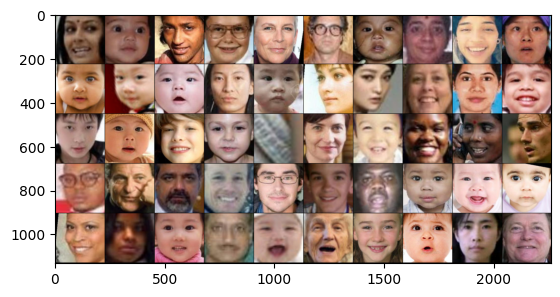

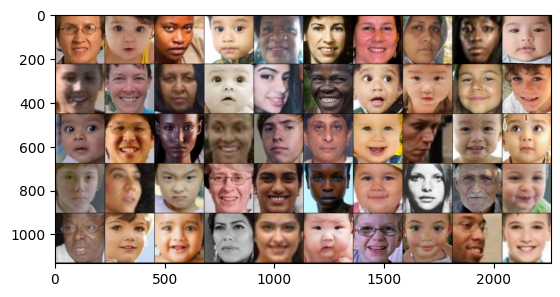

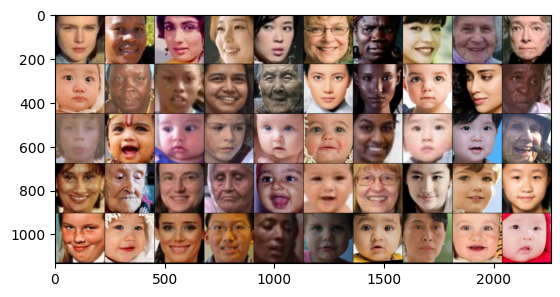

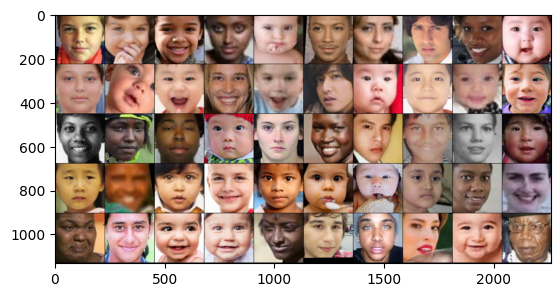

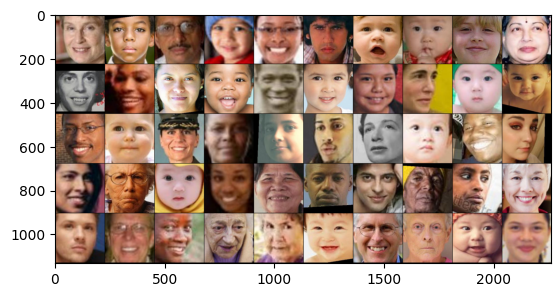

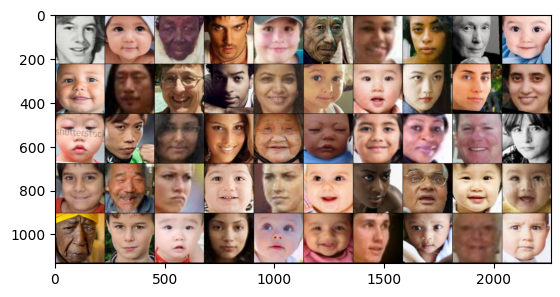

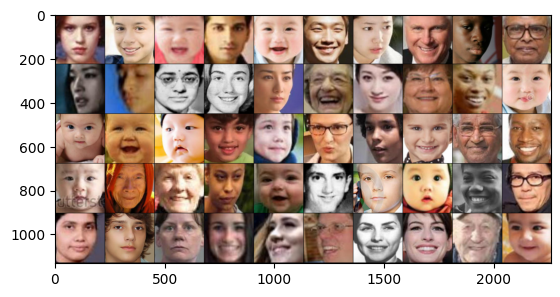

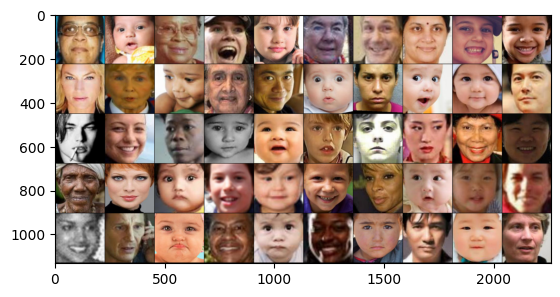

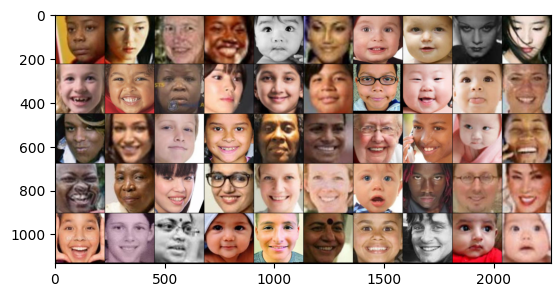

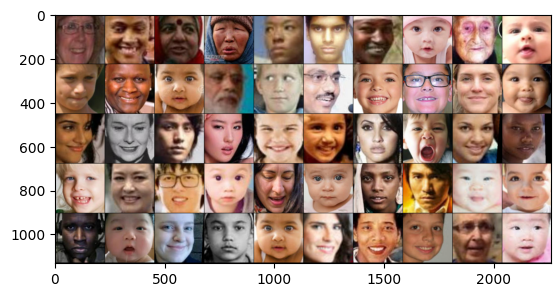

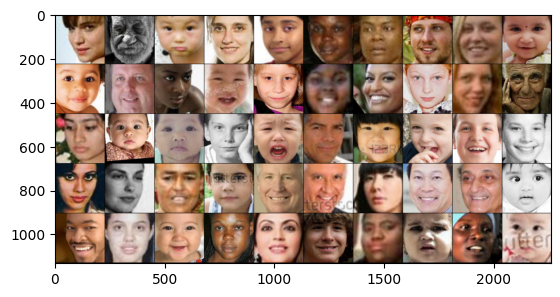

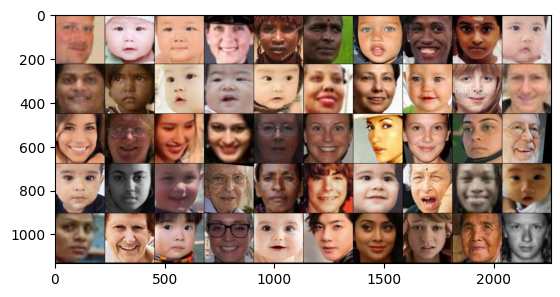

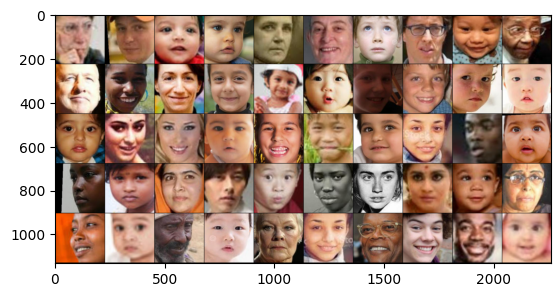

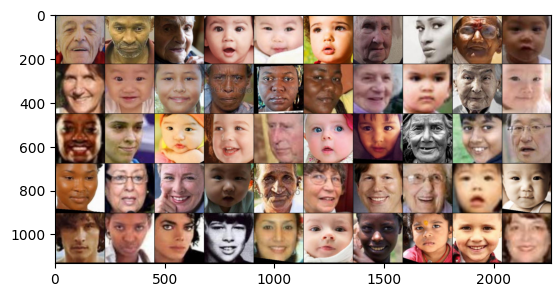

In [67]:
# Create a grid of misclassified images and plot it
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

norm_images = []
for img in misclassified_images:
    norm_images.append(img * std + mean)
    
for i in range(1, 15):
    grid = torchvision.utils.make_grid(norm_images[(i-1)*50:i*50], nrow=10)
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

# Print the labels of the misclassified images
# print("Misclassified labels:", misclassified_labels[16:32])

In [74]:
torch.save(misclassified, 'color_misclassified_images.pt')

In [94]:
transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

ages = []
ethnicities = []

for filename in os.listdir("UTKFace_test"):    
    # open the image file and convert it to a NumPy array
    if (filename == ".DS_Store"):
        continue
    with Image.open(os.path.join("UTKFace_test", filename)) as img:
        
        parts = filename.split("_") 
        age = int(parts[0])
        gender = int(parts[1])
        ethnicity = int(parts[2])
        
        tensor = transform(img)
        
        for t in misclassified_images:
            if torch.allclose(t, tensor):
                ethnicities.append(ethnicity)
                ages.append(age)
        counter += 1
        if counter % 500 == 0:
            print(counter)


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [107]:
arr = np.array(ages)
print(np.sum(arr >= 0) - np.sum(arr > 5)) 
print(np.sum(arr >= 80))
# 215 between 0 and 5 inclusive
# 32 greater than or equal to 80 (i.e. 80 to 116)

215
32


In [88]:
norm_images[50]
if norm_images[0] in norm_images:
    print("hi")

hi
